In [3]:
import os
import sys
from glob import glob

import warnings

from sklearn import metrics, exceptions

import rasterio as rio
from rasterio.plot import show

from re import match

import numpy as np

import pandas as pd

from subprocess import Popen

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Appendix: Coarsen ASO to Comparators

We're re-implementing `compare-metrics.py` to create a dataframe with several classification metrics for several SCA products (ours [CubeSat/ML], thresholded Sentinel-2 NDSI, and thresholded LS8 fSCA) *with reference to ASO baseline*. 

The difference here is that prior to computing metrics we upsample ASO via nearest-neighbor resampling to the resolution of the SCA product being compared against, for fairness. 

We've got a list of candidate Planet images, each containing overlapping comparator images (S2, LS8) that have been thresholded and loosely clipped to the imagery AOI. We will create a `coarsened` folder with VRT comparators (2 band rasters) for each product being compared against. We'll clip this with the data region and use sklearn to compute metrics. 

## Find image directories

In [4]:
root = '/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/ASO_3M_SD_USCATE_20180528/'

In [5]:
# image_ids = open(os.path.join(root, "selected_images.txt")).read().strip().split('\n')
image_ids = open(os.path.join(root, "selected_images_rework.txt")).read().strip().split('\n')


In [6]:
image_dirs = [glob(os.path.join(root, f"*{id}*"))[0] for id in image_ids]

In [7]:
assert len(image_dirs) == len(image_ids), "An ID specified was not found."

In [8]:
image_dirs

['/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/ASO_3M_SD_USCATE_20180528/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180528_181108_1025_3B_AnalyticMS_SR_clip',
 '/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/ASO_3M_SD_USCATE_20180528/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180528_181109_1025_3B_AnalyticMS_SR_clip',
 '/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/ASO_3M_SD_USCATE_20180528/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180528_181110_1025_3B_AnalyticMS_SR_clip',
 '/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/ASO_3M_SD_USCATE_20180528/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180528_181111_1025_3B_AnalyticMS_SR_clip',
 '/Volumes/wrangell-st-e

## Find Test Output Directories

Each image directory contains a directory containing all assets to compare (e.g. ASO, ML predictions, Sentinel2 NDSI, LS8 fSCA). The directory title is an MD5 hashes of the input files, we can match with `^[a-f0-9]{32}$`.

In [9]:
md5_pattern = "^[a-f0-9]{32}$"

In [10]:
# example
def get_comparator_dir(d):
    comparator_dir = None
    dirs = [f for f in os.listdir(d) if match(md5_pattern, f)]
    if len(dirs) == 1:
        comparator_dir = dirs[0]
    elif len(dirs) > 1: 
        print(f"{d} more than one comparator!")
        # get most recent based on modified time
        mtimes = [os.stat(os.path.join(d, _d)).st_mtime for _d in dirs] 
        comparator_dir = dirs[np.argsort(mtimes)[::-1][0]] 
    else:
        raise ValueError("Not Found")
        
    return os.path.join(d, comparator_dir)
    

In [11]:
comparator_dirs = [get_comparator_dir(d) for d in image_dirs]

In [12]:
os.listdir(comparator_dirs[0])

['.DS_Store',
 '20180528_181108_1025_3B_AnalyticMS_SR_clip_merged.tif',
 'ASO_merged.tif',
 'coarsened',
 'data_region.geojson',
 'LC08_CU_003009_20180603_20190615_C01_V01_SNOW_05_reprojected_clipped.tif',
 'NDSI_reprojected_clipped.tif']

## Coarsen ASO to match for each comparison

In [13]:
data_region_slug = "data-mask.geojson"

In [14]:
def coarsen(asoPath, comparatorPath, outdir=None, data_region=None):
    """
    Creates a virtual raster with ASO and comparator stacked (aso band 1).
    
    Uses data_region.geojson in the ASO directory to clip the VRT. 
    """
    

    
    gdalCmd = "source activate qgis && "\
              'gdalbuildvrt -overwrite -resolution lowest -separate -r nearest -vrtnodata "-9999 -9999" {output}.vrt {aso} {comparator} && '\
              "gdalwarp -overwrite -cutline {cutline} -crop_to_cutline -dstnodata -9999 {output}.vrt {output}_clipped.vrt "
    
    if outdir is None:
        outdir = os.path.join(os.path.dirname(asoPath), "coarsened")
        os.makedirs(outdir, exist_ok=True)
        

    comparatorOutfileRoot = os.path.join(outdir, "ASO_vs_"+os.path.splitext(os.path.basename(comparatorPath))[0])
    if data_region:
        cutlinePath = data_region
    else: 
        cutlinePath = os.path.join(os.path.dirname(asoPath), "data_region.geojson")
    
    _cmd = gdalCmd.format(aso = asoPath, comparator = comparatorPath, output = comparatorOutfileRoot, cutline=cutlinePath)
    Popen(_cmd, shell=True).communicate()
    
    return(os.path.join(outdir, comparatorOutfileRoot+"_clipped.vrt"))
    
        


In [15]:
!stat {os.path.join(os.path.dirname(comparator_dirs[0]), data_region_slug)}

16777223 358989 -rw-r--r-- 1 tony staff 0 1106 "Mar  4 15:11:41 2020" "Mar  4 10:29:33 2020" "Mar  4 10:29:33 2020" "Mar  4 10:29:33 2020" 4096 16 0 /Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/ASO_3M_SD_USCATE_20180528/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180528_181108_1025_3B_AnalyticMS_SR_clip/data-mask.geojson


In [16]:
result = coarsen(glob(os.path.join(comparator_dirs[0], "ASO*"))[0], glob(os.path.join(comparator_dirs[0], "*SNOW*.tif"))[0], data_region = os.path.join(os.path.dirname(comparator_dirs[0]), data_region_slug))

In [17]:
result


'/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/ASO_3M_SD_USCATE_20180528/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180528_181108_1025_3B_AnalyticMS_SR_clip/c8099c28f0abf143501bbcbfb84ba197/coarsened/ASO_vs_LC08_CU_003009_20180603_20190615_C01_V01_SNOW_05_reprojected_clipped_clipped.vrt'

In [18]:
! open $(dirname {result})

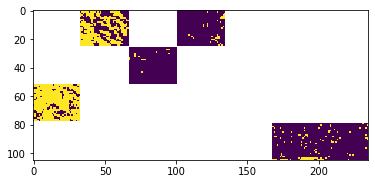

In [19]:
resultData = rio.open(result)
show(resultData.read(1, masked=True))

In [20]:
aso = resultData.read(1, masked=True)
comparator = resultData.read(2, masked=True)

In [21]:
len(aso.data[~aso.mask])

5184

In [22]:
len(comparator.data[~comparator.mask])

5285

In [23]:
diff = (aso - comparator)

## Compute Performance Metrics

In [24]:
def compute_performance(true, pred, nodata=-9999):
    
    mask = true.mask
    true = true.data[~mask]

    pred = pred.data[~mask]
    
    if len(np.unique(true)) != len(np.unique(pred)):
        if len(np.unique(true)) > len(np.unique(pred)):
            true[true == nodata] = 0
        else:
            pred[pred == nodata] = 0

    assert(pred.shape == true.shape)

    print (np.unique(true), np.unique(pred))
    
    with warnings.catch_warnings():
        warnings.filterwarnings('error')

        try: 
            performance = metrics.precision_recall_fscore_support(true, pred, average = 'binary')

            accuracy = metrics.balanced_accuracy_score(true, pred)

            kappa = metrics.cohen_kappa_score(true, pred)
        except exceptions.UndefinedMetricWarning:
            print("One or more metrics Undefined. Skipping.")
            return None

    result = {
        "Precision": performance[0],
        "Recall" : performance[1],
        "F-Score": performance[2],
        "Balanced Accuracy": accuracy,
        "Kappa" : kappa
    }

    return result

In [25]:
ans = compute_performance(aso, comparator)

[0 1] [0 1]


In [26]:
pd.DataFrame.from_dict({os.path.splitext(os.path.basename(result))[0].split("_vs_")[1]:ans}, orient='index')

,Precision,Recall,F-Score,Balanced Accuracy,Kappa
LC08_CU_003009_20180603_20190615_C01_V01_SNOW_05_reprojected_clipped_clipped,0.369727,0.880355,0.520751,0.674903,0.241843


## Apply to All Images

In [27]:
ASO_glob = "ASO*merged.tif"
comparison_res = [
    "*AnalyticMS_SR_clip_merged.tif", # ML prediction
    "*SNOW_05*", # LS8 fSCA, 
    "NDSI*.tif" # sentinel 2
]

In [28]:
comparisons = []
for comparator in comparator_dirs:    
    these_comparisons = []
    this_ASO = glob(os.path.join(comparator, ASO_glob))[0]
    for to_compare in comparison_res:
        this_comparator = glob(os.path.join(comparator, to_compare))[0]
        these_comparisons.append(coarsen(this_ASO, this_comparator))
        
    comparisons.append(these_comparisons)
        
        
    

In [29]:
all_metrics = []
for comparator, these_comparisons in zip(comparator_dirs, comparisons):
    imageid = comparator.split('/')[-2].split(":")[-1]
    
    perf_metrics = []
    for comparison in these_comparisons:
        # e.g. ASO_vs_<ndsi/ls8/etc>.tif, get comparison type
        compared_to = os.path.splitext(os.path.basename(comparison))[0].split("_vs_")[1]
        this_comparison = rio.open(comparison)
        perf_metrics.append(pd.DataFrame.from_dict({
            compared_to : compute_performance(
                            this_comparison.read(1, masked=True),
                            this_comparison.read(2, masked=True))
        }, orient='index'))
    
    tmp_df = pd.concat(perf_metrics)
    tmp_df['image_id'] = imageid
    all_metrics.append(tmp_df)

[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]


In [30]:
all_results = pd.concat(all_metrics)

## Plot Results

Must reshape for plotting. 

In [31]:
preds = all_results[all_results.index.str.contains("AnalyticMS")]
s2 = all_results[all_results.index.str.contains("NDSI")]
ls8 = all_results[all_results.index.str.contains("SNOW")]

preds = preds.reset_index(drop=True)
preds["SCA"] = "CubeSat ML"

s2 = s2.reset_index(drop=True)
s2["SCA"] = "Sentinel 2 NDSI"

ls8 = ls8.reset_index(drop=True)
ls8["SCA"] = "Landsat 8 fSCA"

In [32]:
all_reshaped = pd.concat([preds, s2, ls8]).drop(['image_id'], axis=1)

In [33]:
melted = pd.melt(all_reshaped.reset_index(), id_vars=['index', 'SCA'])
melted.value = pd.to_numeric(melted.value)

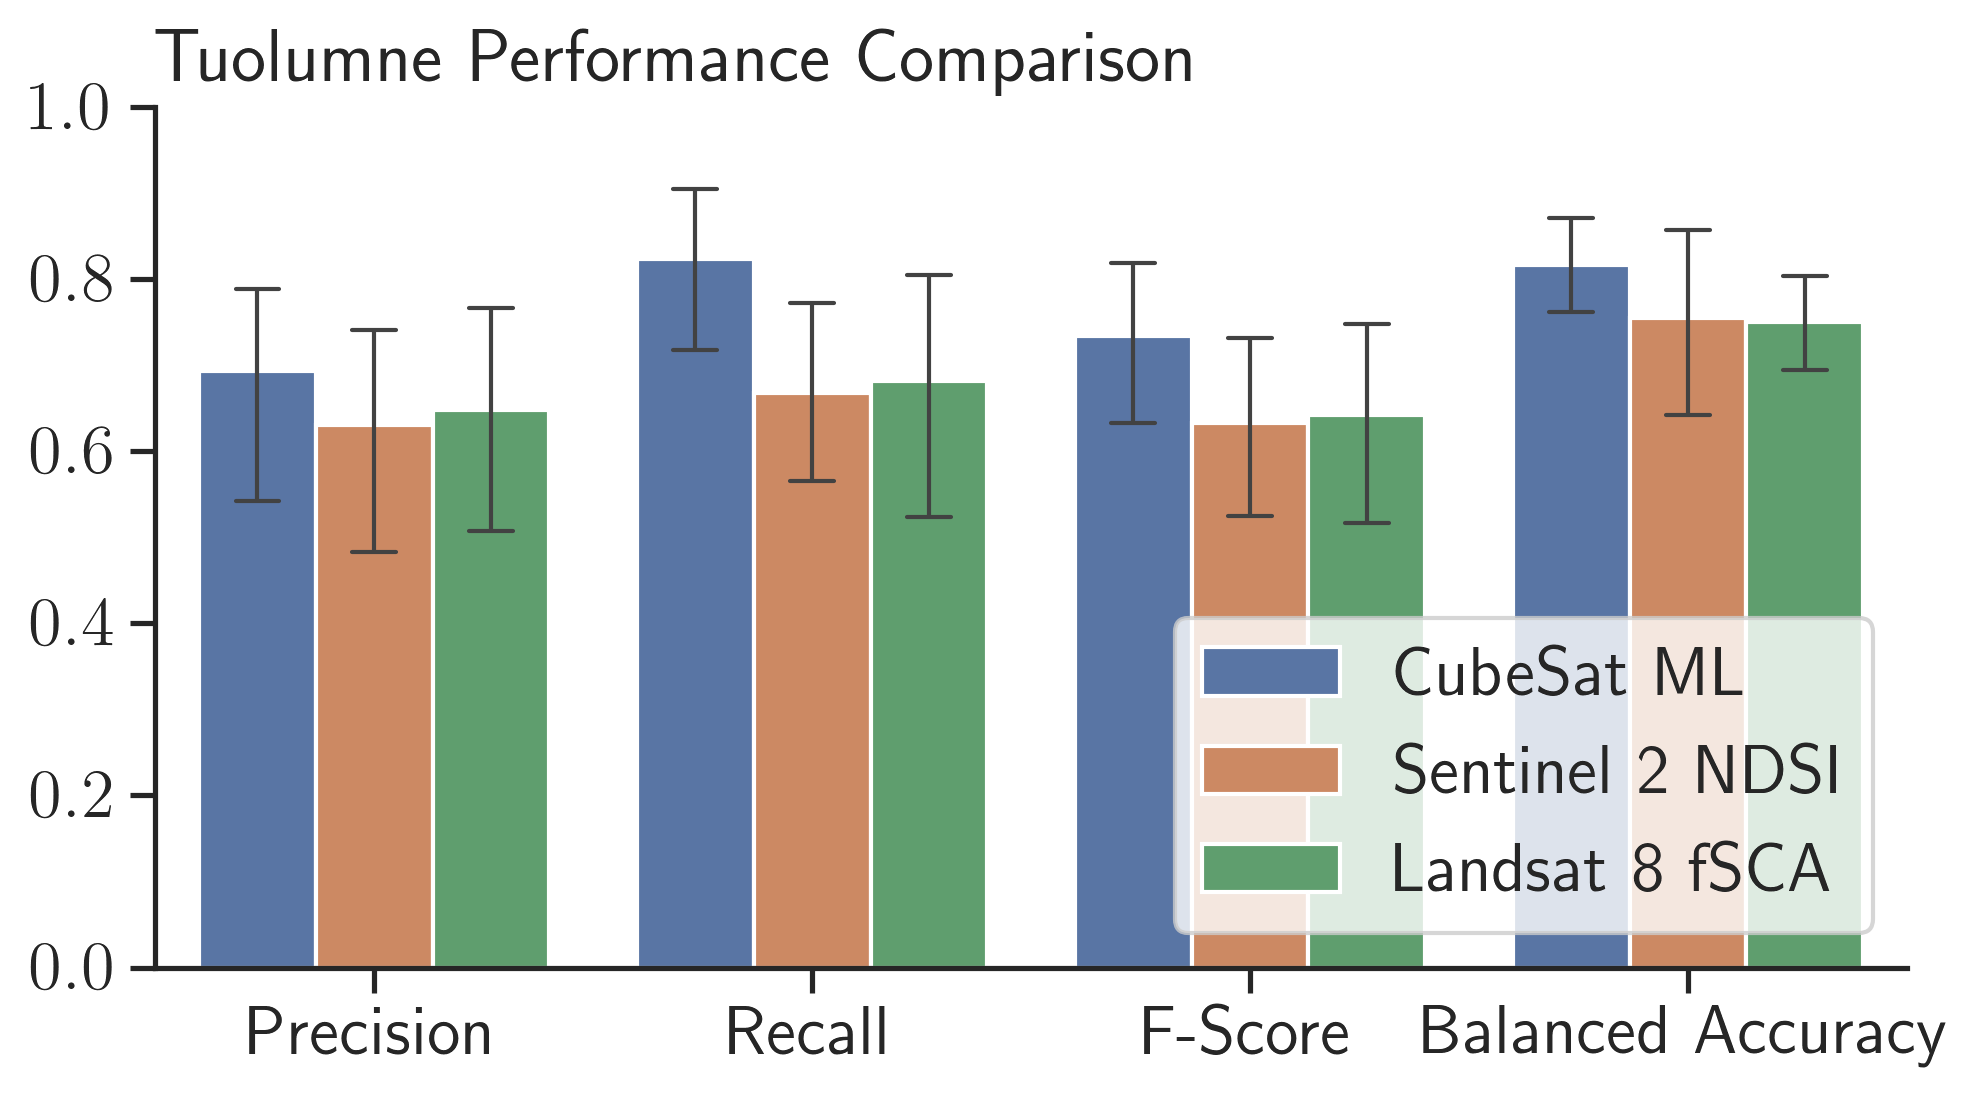

In [44]:
plt.rc('text', usetex=True)
sns.set(style='ticks', font_scale=1.5)

fig, ax = plt.subplots(figsize=(7,4), dpi=300)

bp = sns.barplot(x='variable', hue='SCA', y = 'value', data=melted, ax= ax, order=['Precision', "Recall", "F-Score", "Balanced Accuracy"], capsize=0.1, errwidth=1)
plt.ylim([0, 1])

plt.xlabel("")
plt.ylabel("")
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
bp.legend(title=None, loc='lower right')
sns.despine()
plt.title("Tuolumne Performance Comparison", loc='left')
plt.tight_layout()


plt.savefig("performance-reworked.png", dpi=300, bbox_inches='tight')

# test_results = add_stat_annotation(ax, data=melted2, x='variable', y='value', hue='SCA',
#                                    box_pairs=box_pairs,
#                                    test='t-test_ind', text_format='star',
#                                    loc='outside', verbose=2)
# plt.savefig("tuol-sentinel-ml-performance_sig.png", dpi=300, bbox_inches='tight')